# Audience Decode: Behavioral Analysis Project

**Team Members:** Yelena Shabanova, Alena Seliutina, Luis Fernando Henriquez Patino

---

### **Introduction**

This project aims to analyze viewer engagement and behavioral patterns from the `viewer_interactions.db` dataset. As per the "Audience Decode" brief, our goal is not to predict individual ratings, but to explore and model audience behavior.

We will use **Unsupervised Learning (Clustering)** to achieve this, focusing on:
1.  **User Segmentation:** Identifying distinct groups of users based on their rating behaviors (e.g., "Critical Power Users", "Casual Viewers").
2.  **Behavioral Analysis:** Understanding how these groups interact with different types of content and how preferences may evolve.

**Note on "Genre":** The project brief mentions "genres," but this data is not in the provided database. As a first step, we will proceed by using `year_of_release` as a proxy to analyze preferences for "movie eras" (e.g., "Classics," "Modern Films"). We will note this as a potential area for future data enrichment.

### **Table of contents** 
1. **ENVIRONMENT SETUP** 
2. **DATA LOADING**  

3. **EXPLANATORY DATA ANALYSIS**  
   3.1 EDA: USER BEHAVIOR ANALYSIS  
   3.2 EDA: MOVIES  

4. **DATA PREPROCESSING**  
   4.1 User Feature Matrix  
   4.2 Movie Feature Matrix  
   4.3 Preprocessing Summary  

5. **MOVIE CLUSTERING**  
   5.1 Selecting the Number of Clusters  
   5.2 Fitting K-Means Model  
   5.3 PCA Reduction for Visualization  
   5.4 Cluster Interpretation  
   5.5 Movie Pseudo-Genres  

6. **USER CLUSTERING**  
   6.1 K-MEANS (FULL DATASET)  
   6.2 DBSCAN (SAMPLING)  
   6.3 GMM - Gaussian Mixture Model (SAMPLING)  
   6.4 MODEL COMPARISON  
   6.5 Interpretation of K-Means User Clusters  
   6.7 Naming User Clusters   
7. **USER-MOVIE PREFERENCES**

## SECTION 1: ENVIRONMENT SETUP

First, we import all necessary libraries for data loading, analysis, visualization, and machine learning.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# Clustering Models
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch

# Model Evaluation
from sklearn.metrics import silhouette_score

# Set styles and options
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
sns.set_palette("Set2")
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#test
print("Libraries imported successfully.")

Libraries imported successfully.


## SECTION 2: DATA LOADING

We connect to the database (`viewer_interactions.db`) and load the key tables into pandas DataFrames.

* `user_statistics`: Pre-computed behavioral data for each user (our main features).
* `movie_statistics`: Pre-computed data for each movie.
* `movies`: Basic metadata for movies (title, year).

In [2]:
DB_PATH = 'viewer_interactions.db'
#TEEESSSTTT
try:
    conn = sqlite3.connect(DB_PATH)
    
    # Load user statistics - this will be our primary table for user clustering
    df_users = pd.read_sql_query("SELECT * FROM user_statistics", conn)
    
    # Load movie statistics - useful for EDA and potential movie clustering
    df_movies = pd.read_sql_query("SELECT * FROM movie_statistics", conn)
    
    # Load movie metadata
    df_movies_meta = pd.read_sql_query("SELECT * FROM movies", conn)
    
    print(f"Successfully loaded {len(df_users)} users.")
    print(f"Successfully loaded {len(df_movies)} movies.")

except Exception as e:
    print(f"Error connecting to or reading from the database: {e}")
    print("Please ensure 'viewer_interactions.db' is in the same folder as this notebook.")

finally:
    if 'conn' in locals() and conn:
        conn.close()
        print("Database connection closed.")

Successfully loaded 438780 users.
Successfully loaded 16015 movies.
Database connection closed.


In [3]:
# Display the first few rows of the user data
if 'df_users' in locals():
    print("User Statistics Head:")
    display(df_users.head())

User Statistics Head:


,customer_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_movies,first_rating_date,last_rating_date,activity_days
0,1965326,8.000,3.250,0.886,2.000,5.000,8.000,2004-08-11,2005-06-06,299.000
1,506434,1.000,4.000,NaN,4.000,4.000,1.000,2005-08-02,2005-08-02,0.000
2,1365167,3.000,4.667,0.577,4.000,5.000,3.000,2004-11-16,2005-01-19,64.000
3,396632,2.000,NaN,0.000,4.000,4.000,2.000,2004-07-07,2004-07-07,0.000
4,260614,3.000,4.333,0.577,4.000,5.000,3.000,2004-03-02,2004-10-13,NaN


## SECTION 3:  EDA
## 3.1 EDA: USER BEHAVIOR ANALYSIS

Before we can model behavior, we must understand it. We will perform an EDA to analyze the distributions of our data. Using (`user_statistics`), our goal is to understand viewer activity patterns and the distributions of key behavioral features. After we'll be able to cluster users based on shared patterns.

### **User Statistics Summary**

In [4]:
print("User Statistics Summary:")
display(df_users[['total_ratings', 'avg_rating', 'std_rating', 'unique_movies', 'activity_days']].describe())

User Statistics Summary:


,total_ratings,avg_rating,std_rating,unique_movies,activity_days
count,416841.000,416841.000,332528.000,416841.000,416841.000
mean,9.287,3.632,0.898,9.235,275.437
std,14.299,0.812,0.457,13.407,389.073
min,1.000,0.000,0.000,1.000,0.000
25%,2.000,3.185,0.645,2.000,0.000
50%,4.000,3.688,0.868,4.000,102.000
75%,11.000,4.000,1.155,11.000,408.000
max,764.000,6.000,3.536,764.000,3941.000


The table above provides an overview of key behavioral metrics for nearly half a million users. These features help us understand how viewers engage with the platform.

#### Interpretation:
- **`total_ratings`** is highly right-skewed: most users rate only a few titles, while a small minority rate dozens or even hundreds.
- **`avg_rating`** varies widely across users, indicating different rating styles (e.g., harsh vs. generous raters).
- **`std_rating`** shows how consistent a user is in their scoring behavior.
- **`unique_movies`** closely mirrors `total_ratings`, confirming that users rarely re-rate the same film.
- **`activity_days`** captures long-term engagement and contributes additional behavioral context.

These statistics justify clustering users based on both activity and rating style, as the user base is highly heterogeneous.

### **Distribution of Total Ratings per User**

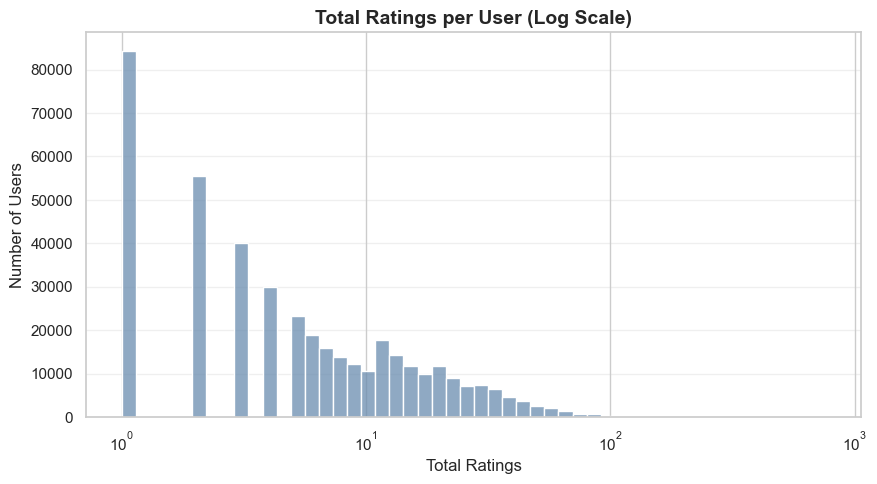

In [5]:
plt.figure(figsize=(10,5))
sns.histplot(df_users['total_ratings'], bins=50, log_scale=True, color="#6A8CAF")
plt.title("Total Ratings per User (Log Scale)", fontsize=14, fontweight='bold')
plt.xlabel("Total Ratings")
plt.ylabel("Number of Users")
plt.grid(axis='y', alpha=0.3)
plt.show()

This histogram shows how many ratings each user has submitted. Because the distribution is extremely skewed, a logarithmic x-axis is used to visualize both the dense mass of low-activity users and the long tail of highly active users.

#### Interpretation
**Most users rate very few movies:**  
- The majority provide 1-5 ratings, indicating very light engagement. 
- 75% of users rate **fewer than 11** movies.

**Moderately active users are less common:**  
- Users rating **20–50 movies** form a noticeable but smaller segment.

**A long tail of "power users" exists but is extremely rare:**  
  - A tiny fraction rate **100+ movies**.  
  - The maximum user activity is **764 ratings**, but users above 100 ratings are so rare that they appear as nearly invisible bars on the log-scale histogram.

The contrast highlights the extremely uneven engagement pattern in the dataset. This justifies treating **user activity as a primary dimension** in later clustering.

### **Distribution of Average Rating Given**

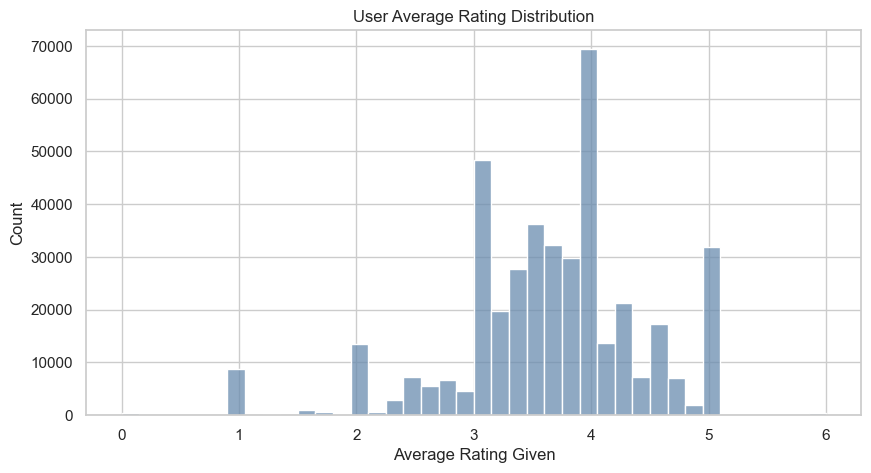

In [6]:
plt.figure(figsize=(10,5))
sns.histplot(df_users['avg_rating'], bins=40, kde=False, color="#6A8CAF")
plt.title("User Average Rating Distribution")
plt.xlabel("Average Rating Given")
plt.ylabel("Count")
plt.show()

This histogram shows how generous or harsh users tend to be on average.

#### Interpretation
- Most users have an average rating between **3.0 and 4.0**, showing a general positive bias.
- Distinct spikes appear near whole-number values because ratings are inherently discrete (1–5).
- A noticeable number of users consistently give low or high average scores, suggesting meaningful variation in rating tendencies.

The histogram highlights diversity in rating style, which is another important dimension for user segmentation.

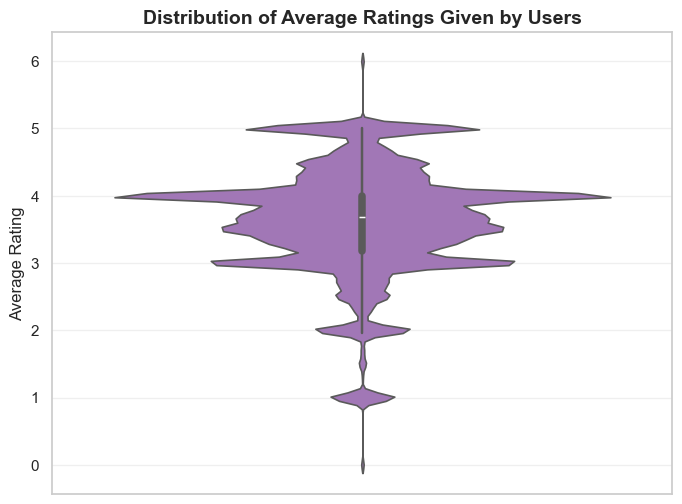

In [7]:
plt.figure(figsize=(8,6))
sns.violinplot(y=df_users['avg_rating'], inner='box', linewidth=1.2, color="#A56CC1")
plt.title("Distribution of Average Ratings Given by Users", fontsize=14, fontweight='bold')
plt.ylabel("Average Rating")
plt.grid(axis='y', alpha=0.3)
plt.show()

The violin plot reveals the **full shape** of the distribution, complementing the histogram above.

#### Interpretation
- The densest region lies around **3.5–4.0**, confirming most users tend to rate positively.
- Thin tails at both extremes indicate a smaller group of consistently very harsh or very generous users.
- Distribution is not symmetric, the shape shows substantial variability, which becomes relevant when analyzing rating stability in next section.

 ### **Does User Activity Affect Rating Consistency?**

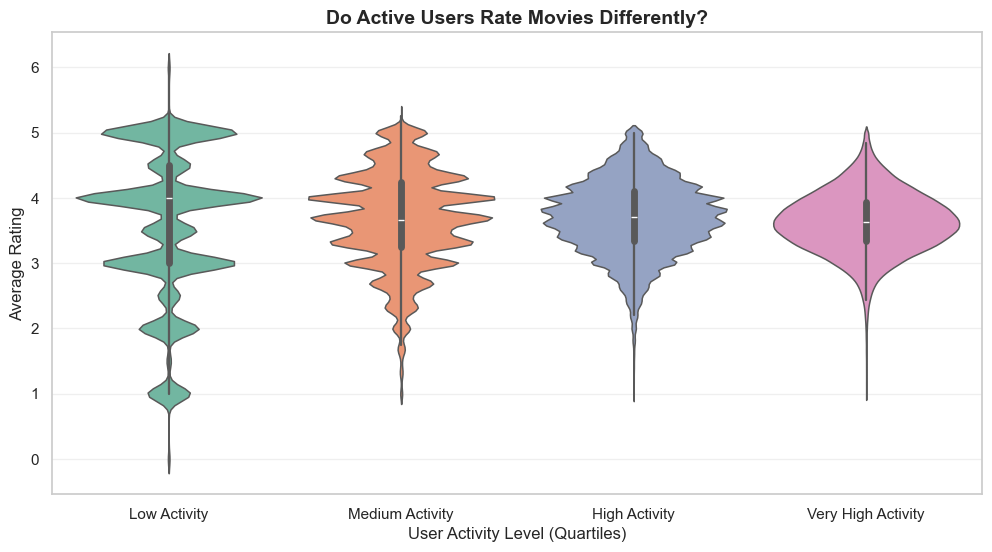

In [8]:
# Bin users into activity quartiles
df_users['activity_bin'] = pd.qcut(df_users['total_ratings'], q=4, labels=["Low Activity", "Medium Activity", "High Activity", "Very High Activity"])

plt.figure(figsize=(12,6))
sns.violinplot(data=df_users, x='activity_bin', y='avg_rating', inner='box', linewidth=1.1, palette='Set2')

plt.title("Do Active Users Rate Movies Differently?", fontsize=14, fontweight='bold')
plt.xlabel("User Activity Level (Quartiles)")
plt.ylabel("Average Rating")
plt.grid(axis='y', alpha=0.3)
plt.show()

Users were grouped into **activity quartiles** based on `total_ratings`. A violin plot compares the **distribution** of average ratings across activity quartiles, showing the relationship between activity level and rating behavior.

#### Interpretation
**Mean ratings remain similar** across all activity levels — there is no linear shifts in average rating as user activity increases. *What does change is the spread:*
- **Low-activity users** display a much wider variability in average ratings, including extreme values.
- **Medium and high-activity users** concentrate closer to the 3–4 range, suggesting more stable and moderate scoring tendencies.
- **Very high-activity users** show the narrowest spread, indicating the most consistent behavior.

These differences demonstrate that **activity level influences behavioral consistency**, providing important nuance for clustering that should be included when clustering users.

### **Unique Movies vs Total Ratings**

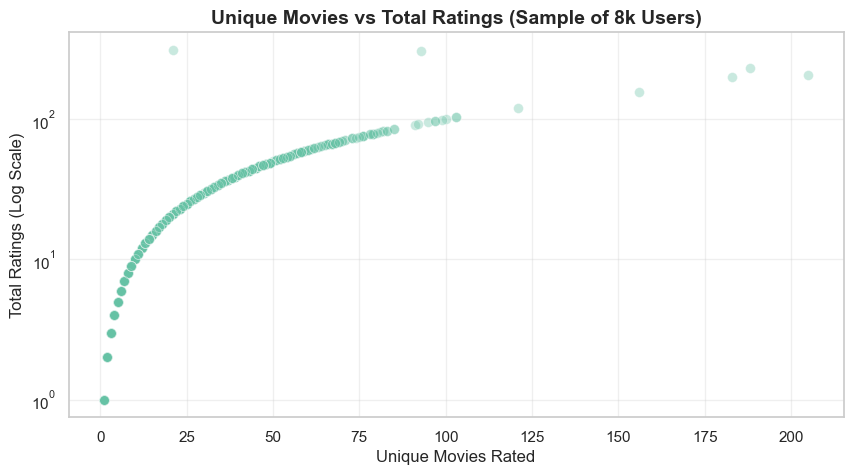

In [9]:
sample_users = df_users.sample(8000, random_state=42)

plt.figure(figsize=(10,5))
sns.scatterplot(
    data=sample_users,
    x='unique_movies',
    y='total_ratings',
    alpha=0.35,
    s=50
)
plt.yscale("log")
plt.title("Unique Movies vs Total Ratings (Sample of 8k Users)", fontsize=14, fontweight='bold')
plt.xlabel("Unique Movies Rated")
plt.ylabel("Total Ratings (Log Scale)")
plt.grid(alpha=0.3)
plt.show()

In the scatterplot above each point represents one user, 
we're using a sample of 8,000 users to avoid overplotting.

#### Interpretation
- Points fall close to a curved line, showing a near-linear relationship between `unique_movies` and `total_ratings`.
- This confirms that users almost never re-rate the same movie.
- The log-scaled y-axis reveals variation across low-activity and high-activity users.

Because these two features are so tightly correlated, using both in clustering may introduce redundancy. The following heatmap confirms this insight quantitatively.

### **Correlation Between User Behavioral Features**

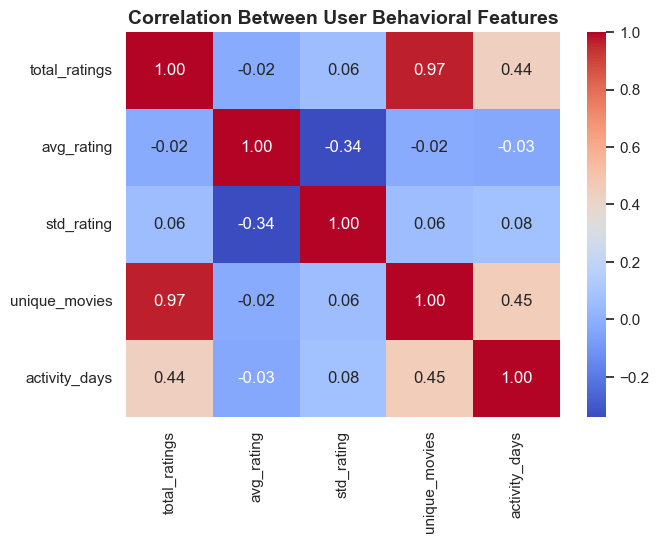

In [10]:
plt.figure(figsize=(7,5))
sns.heatmap(
    df_users[['total_ratings','avg_rating','std_rating',
              'unique_movies','activity_days']].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Between User Behavioral Features", fontsize=14, fontweight='bold')
plt.show()

This heatmap summarizes linear relationships between the most relevant user behavior variables.

#### Interpretation
- **`total_ratings` and `unique_movies`** are almost perfectly correlated (ρ ≈ 0.97), indicating both measure the same behavior.
- **`avg_rating`** shows **no linear correlation** with user activity metrics (`total_ratings`, `unique_movies`, `activity_days`), meaning that on average, highly active users do not systematically rate movies higher or lower than less active users.
- **`std_rating`** is moderately negatively correlated with `avg_rating`, suggesting more generous users tend to be more consistent.
- **`activity_days`** shows a reasonable positive correlation with total ratings, consistent with expectations.

The heatmap guides feature selection for clustering:
- Avoid redundant variables (`total_ratings` and `unique_movies`).
- Combine **activity**, **consistency**, and **rating style** to capture distinct user personas.

## 3.2 EDA: MOVIES
Using (`movie_statistics`), our goal is to understand the movie popularity/rating patterns. Later we'll be able to cluster movies based on explored patterns. This section answers core questions:
	1.	How popular is each movie? (total_ratings distribution)
	2.	How do movies tend to be rated? (avg_rating distribution + violin plot)
	3.	What relationships exist between popularity, rating, controversy, and release year?
	4.	Are there meaningful patterns for clustering movies into “pseudo-genres”?

### **Movie Statistics Summary**

In [11]:
print("Movie Statistics Summary:")
display(df_movies.describe()[[
    'total_ratings',
    'avg_rating',
    'std_rating',
    'year_of_release'
]])

Movie Statistics Summary:


,total_ratings,avg_rating,std_rating,year_of_release
count,15215.000,15215.000,6847.000,11504.000
mean,260.044,3.000,1.258,1990.220
std,3696.939,1.312,0.789,16.334
min,1.000,0.000,0.000,1896.000
25%,1.000,2.000,0.707,1985.000
50%,1.000,3.000,1.222,1997.000
75%,2.000,4.000,1.732,2002.000
max,173598.000,6.000,4.243,2005.000


This table provides a quick overview of movie-level statistics derived from all user ratings. Before exploring the plots, it is useful to understand the distribution of movie-level metrics.

#### Interpretation

**Popularity is extremely skewed**:  
  - The median movie receives **1 rating**.  
  - 75% of movies receive **2 or fewer ratings**.  
  - Only a tiny fraction reach anywhere above **100 ratings**.
  - Few films reach **10 000+ ratings** (up to 173 598).

**Average ratings are centered around 3.0**, with a typical spread of about 0.8.  
  This suggests that most movies receive moderately positive reviews.

**Rating variability (std_rating)** is usually between **0.7 and 1.3**, indicating that user opinions are generally consistent.  
  A few movies have very high variability, marking them as controversial.

**Release years span 1896–2005**, but the distribution is mostly flat and uncorrelated with other features.

Overall, the table confirms that the movie catalog contains **many obscure movies**, a moderate number of mid-known movies, and a **tiny number of blockbusters**.  
This extreme imbalance will strongly shape the interpretation of all following plots.

### **Distribution of Movie Popularity**

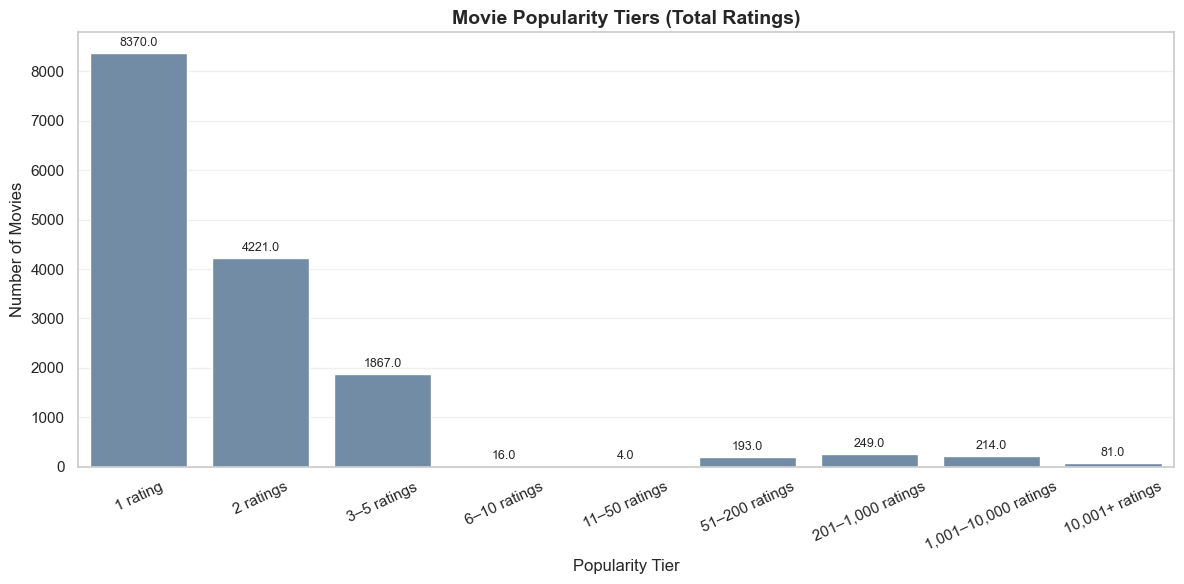

In [12]:
# Improved popularity tiers
bins = [0, 1, 2, 5, 10, 50, 200, 1000, 10000, df_movies['total_ratings'].max()]
labels = [
    "1 rating",
    "2 ratings",
    "3–5 ratings",
    "6–10 ratings",
    "11–50 ratings",
    "51–200 ratings",
    "201–1,000 ratings",
    "1,001–10,000 ratings",
    "10,001+ ratings"
]

df_movies['popularity_bin'] = pd.cut(
    df_movies['total_ratings'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

plt.figure(figsize=(12,6))
ax = sns.countplot(
    data=df_movies,
    x='popularity_bin',
    order=labels,
    color="#6A8CAF"
)

plt.title("Movie Popularity Tiers (Total Ratings)", fontsize=14, fontweight='bold')
plt.xlabel("Popularity Tier")
plt.ylabel("Number of Movies")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=25)

# Annotate counts
for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(
        f"{height}",
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='bottom',
        fontsize=9,
        xytext=(0, 3),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()


#### Interpretation
To better understand the extreme skew in movie popularity, we group movies into meaningful popularity ranges.

- The first two categories, **“1 rating”** and **“2 ratings”**, dominate the catalog  
  (together they account for over **12,000 movies**): most titles were rated only once or twice.

- The **“3–5 ratings”** tier still contains a large number of movies (~1,800),  
  but after that the distribution drops off a cliff.

- The **“6–10”** and **“11–50”** tiers contain only a **handful** of titles, showing that very few movies sit in this intermediate space.

- Popularity then rises slightly again for:
  - **“51–200 ratings”** and **“201–1,000 ratings”** – a few hundred mid-popular films with a visible but not massive audience.
  - **“1,001–10,000 ratings”** – around two hundred well-known mainstream titles.
  - **“10,001+ ratings”** – about **80 true blockbusters**, with the most popular movie reaching **173,598 ratings**.

This tiered view makes the long-tail structure of the catalog clear:  
the platform is dominated by **very obscure movies**, with a much smaller group of mid-popular titles and a tiny set of highly popular blockbusters.  
Popularity is therefore a crucial dimension to include when clustering movies.

### **Distribution of Average Movie Ratings**

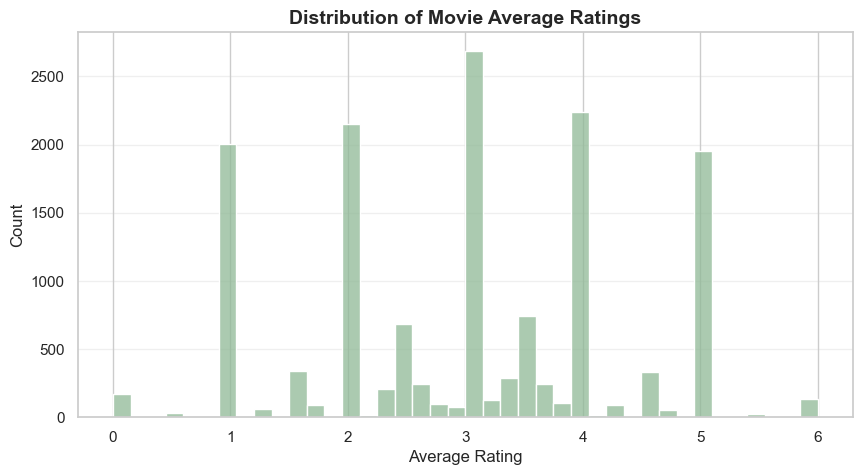

In [13]:
plt.figure(figsize=(10,5))
sns.histplot(df_movies['avg_rating'], bins=40, color="#8FB996")
plt.title("Distribution of Movie Average Ratings", fontsize=14, fontweight='bold')
plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

#### Interpretation

Movie average ratings cluster strongly around integer values (1, 2, 3, 4, 5), reflecting the discrete nature of the rating system.

Key observations:

- Most movies fall between **2.5 and 4.0**.  
- Very low-rated (<1.5) and very high-rated (>4.5) movies are rare.  
- Peaks at integer values occur because movies with very few ratings often have an average equal to their single rating.

Overall, movie quality scores are moderately positive, and extremely negative or extremely positive movies are uncommon.

### **Rating Variability (Controversy) Distribution**

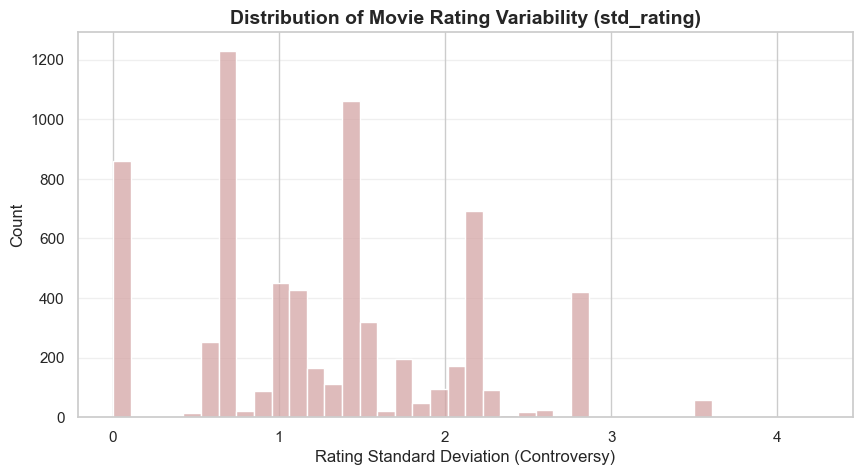

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(df_movies['std_rating'], bins=40, color="#D4A5A5")
plt.title("Distribution of Movie Rating Variability (std_rating)", fontsize=14, fontweight='bold')
plt.xlabel("Rating Standard Deviation (Controversy)")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

#### Interpretation
**Most movies have a standard deviation between 0.7 and 1.3**, meaning users generally agree about their quality.

**A smaller number of movies show higher variability (2.0 - 3.0)**, indicating:
- controversial themes
- niche appeal
- movies whose style divides audiences (love/hate reactions)

**A few movies have very high standard deviation (>3.0)**, marking them as extreme outliers in terms of controversy.

This "controversy" dimension helps differentiate stable movies from polarizing ones when forming clusters.

### **Relationship Plots (Scatter + Log Scales)**
We check whether movie features correlate, sampling 10k movies at max to avoid overplotting.

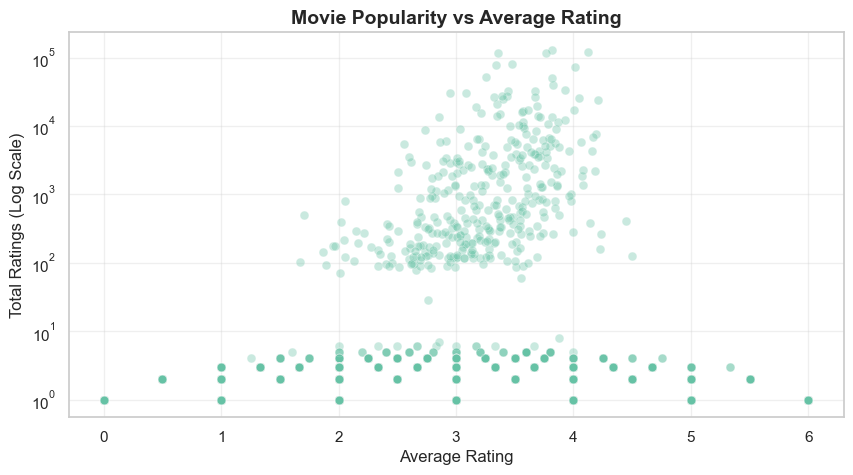

In [15]:
# ============================
# POPULARITY VS AVERAGE RATING
# ============================

sample_movies = df_movies.sample(n=min(8000, len(df_movies)), random_state=42)

plt.figure(figsize=(10,5))
sns.scatterplot(
    data=sample_movies, 
    x='avg_rating', 
    y='total_ratings', 
    alpha=0.35, 
    s=40
)
plt.yscale("log")
plt.title("Movie Popularity vs Average Rating", fontsize=14, fontweight='bold')
plt.xlabel("Average Rating")
plt.ylabel("Total Ratings (Log Scale)")
plt.grid(alpha=0.3)
plt.show()

#### Interpretation 

For the vast majority of movies (those with fewer than ~10 ratings), popularity provides almost no useful signal.  
These movies cluster at the bottom of the plot and produce the flat band near y ≈ 0–10.

Among the small subset of more widely rated movies:

- Popularity spans all rating levels.  
- Highly rated movies are not necessarily popular.  
- Low-rated movies can still be widely watched.

Overall, **movie popularity and perceived quality are largely independent dimensions.**

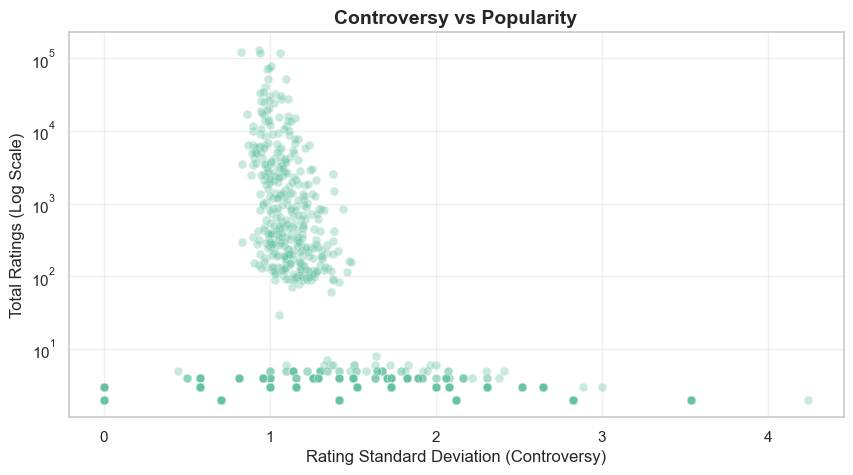

In [16]:
# ============================
# CONTROVERSY VS POPULARITY
# ============================

plt.figure(figsize=(10,5))
sns.scatterplot(
    data=sample_movies, 
    x='std_rating', 
    y='total_ratings', 
    alpha=0.35, 
    s=40
)
plt.yscale("log")
plt.title("Controversy vs Popularity", fontsize=14, fontweight='bold')
plt.xlabel("Rating Standard Deviation (Controversy)")
plt.ylabel("Total Ratings (Log Scale)")
plt.grid(alpha=0.3)
plt.show()

#### Interpretation

The scatter plot again shows that for movies with very few ratings, variability is not meaningful.

Among more popular movies:

- Most fall within a moderate variability range (0.7–1.3).  
- Controversy does not predict how widely a movie is watched.  
- Extremely controversial movies tend to be unpopular, likely because niche films accumulate fewer ratings.

Overall, controversy and popularity appear independent.

### **Correlation Between Movie Features**

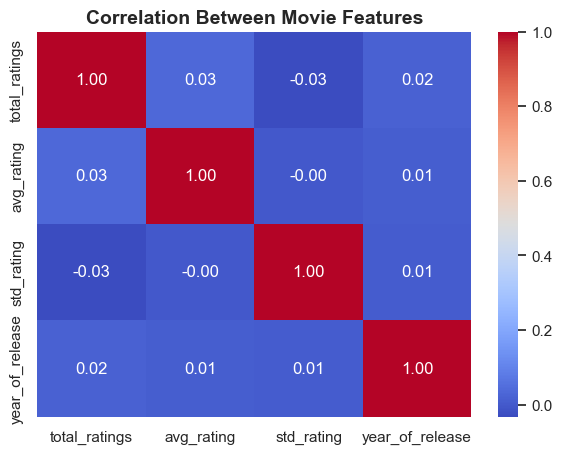

In [17]:
plt.figure(figsize=(7,5))
sns.heatmap(
    df_movies[['total_ratings','avg_rating','std_rating','year_of_release']].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Between Movie Features", fontsize=14, fontweight='bold')
plt.show()

#### Interpretation
The heatmap confirms that:

- **Popularity (total_ratings)** is almost independent from  
  - average rating  
  - rating variability  
  - release year  

- **Average rating and controversy** show no significant relationship.

- **Release year** does not meaningfully affect popularity or rating level in this dataset.

The weak correlations match the behavior observed in the scatter plots: each feature contributes independent information, which is ideal for clustering.

## SECTION 4: DATA PREPROCESSING
Before we can cluster users and movies, we need to:

1. **Select meaningful features** for users and movies.  
2. **Handle missing values** (especially in `std_rating`).  
3. **Scale features** so that variables on large scales (e.g. `total_ratings`) do not dominate smaller ones (e.g. `avg_rating`).

Since clustering is **unsupervised**, we do *not* split the data into train/test sets.  
Instead, we build two clean feature matrices:

- `X_users_kmeans` – standardized user features  
- `X_movies_kmeans` – standardized movie features

These matrices will be the input for K-Means (and other clustering methods) in the next sections.

### 4.1 User Feature Matrix

For users, we want to capture both **activity** and **rating behaviour**.  
We use the following features from `df_users`:

- `total_ratings` – how many ratings the user has submitted  
- `unique_movies` – how many distinct movies they rated  
- `avg_rating` – how generous/strict they are on average  
- `std_rating` – how consistent their ratings are  
- `activity_days` – over how many days they have been active

Some users have missing `std_rating` (e.g. if they rated only one movie).  
We impute missing values using the **median**, then standardize all features using `StandardScaler`.

In [4]:
# 4.1 USER FEATURE MATRIX

user_features = [
    'total_ratings',
    'unique_movies',
    'avg_rating',
    'std_rating',
    'activity_days'
]

# Keep only the selected columns
df_users_features = df_users[user_features].copy()

print("Missing values in raw user features:")
#print(df_users_features.isna().sum()) will show NaNs here.
# 1. FIX: std_rating NaN occurs when total_ratings is 1. Std_dev must be 0.,
single_rating_mask = (df_users_features['total_ratings'] == 1) & (df_users_features['std_rating'].isna())
df_users_features.loc[single_rating_mask, 'std_rating'] = 0.0

# Impute missing values (median is robust to skew)
user_imputer = SimpleImputer(strategy='median')
X_users_imputed = user_imputer.fit_transform(df_users_features)

# Standardize features for KMeans / distance-based methods
user_scaler = StandardScaler()
X_users_kmeans = user_scaler.fit_transform(X_users_imputed)

# Store as DataFrame for easier inspection (indexed by customer_id)
X_users_kmeans_df = pd.DataFrame(
    X_users_kmeans,
    columns=user_features,
    index=df_users['customer_id']
)

print("\nUser feature matrix for clustering (standardized):")
print(X_users_kmeans_df.head())
print(f"\nX_users_kmeans shape: {X_users_kmeans_df.shape}")

Missing values in raw user features:

User feature matrix for clustering (standardized):
             total_ratings  unique_movies  avg_rating  std_rating  \
customer_id                                                         
1965326             -0.073         -0.074      -0.486       0.319   
506434              -0.574         -0.608       0.461      -1.350   
1365167             -0.431         -0.455       1.303      -0.263   
396632              -0.502         -0.532       0.066      -1.350   
260614              -0.431         -0.455       0.882      -0.263   

             activity_days  
customer_id                 
1965326              0.085  
506434              -0.700  
1365167             -0.532  
396632              -0.700  
260614              -0.432  

X_users_kmeans shape: (438780, 5)


### 4.2 Movie Feature Matrix

For movies, we focus on **popularity, quality, controversy, and time**:

- `total_ratings` – how many users rated the movie (popularity)  
- `avg_rating` – average rating (perceived quality)  
- `std_rating` – rating variability (controversy)  
- `year_of_release` – temporal dimension (older vs newer titles)

Many movies have missing `std_rating` (e.g. movies rated only once).  
Again, we impute missing values with the **median** and standardize all features.

In [5]:
# 4.2 MOVIE FEATURE MATRIX

movie_features = [
    'total_ratings',
    'avg_rating',
    'std_rating',
    'year_of_release'
]

df_movies_features = df_movies[movie_features].copy()

print("Missing values in raw movie features:")
print(df_movies_features.isna().sum())

# Impute missing values
movie_imputer = SimpleImputer(strategy='median')
X_movies_imputed = movie_imputer.fit_transform(df_movies_features)

# Standardize for KMeans
movie_scaler = StandardScaler()
X_movies_kmeans = movie_scaler.fit_transform(X_movies_imputed)

# DataFrame version (indexed by movie_id)
X_movies_kmeans_df = pd.DataFrame(
    X_movies_kmeans,
    columns=movie_features,
    index=df_movies['movie_id']
)

print("\nMovie feature matrix for clustering (standardized):")
print(X_movies_kmeans_df.head())
print(f"\nX_movies_kmeans shape: {X_movies_kmeans_df.shape}")

Missing values in raw movie features:
total_ratings       800
avg_rating          800
std_rating         9168
year_of_release    4511
dtype: int64

Movie feature matrix for clustering (standardized):
          total_ratings  avg_rating  std_rating  year_of_release
movie_id                                                        
1                 0.083       0.582      -0.317            0.767
2                -0.028       0.429       0.086            0.837
3                 0.490       0.500      -0.501            0.344
4                -0.029      -0.204       0.127            0.132
5                 0.248       0.719       0.107            0.837

X_movies_kmeans shape: (16015, 4)



#### **Missing Values in User Features**

Several user-level variables had missing values:

- `total_ratings`, `unique_movies`, `avg_rating`, `activity_days`  
  → missing for **21,939 users**, mostly those who submitted very few ratings.

- `std_rating`  
  → missing for **106,252 users**, because a standard deviation cannot be computed when
  a user rated only one movie.

These missing values are **not errors** but a natural consequence of user behaviour.
For example, users who rate only one title will not have enough information to compute
their variance or activity span.

**How we handled it:**  
We imputed all missing user features using the **median**, which is robust for skewed
distributions. Because clustering relies on distance calculations, imputing with the
median avoids artificially stretching or compressing the feature space.

After imputation and scaling, the user feature matrix contained **no missing values**.

---

#### **Missing Values in Movie Features**

Movie-level missingness was more substantial:

- `total_ratings` and `avg_rating`  
  → missing for **800 movies**, typically those with no recorded interactions.

- `std_rating`  
  → missing for **9,168 movies**, because a single rating cannot produce variance.

- `year_of_release`  
  → missing for **4,511 movies**, originating from the metadata table.

This raised a methodological decision point:

---

#### **Decision: Should we drop or impute `year_of_release`?**

We had two options:

**Option A — Drop `year_of_release`**  
This would avoid imputing many missing years, but we would lose an important dimension for movie behaviour.

**Option B — Impute `year_of_release` (chosen)**  
This preserves the temporal component, which matters for the project because:

- audience preferences can shift over time  
- year interacts with popularity (older films tend to accumulate ratings differently)
- the Audience Decode brief emphasizes **temporal analysis**  
- the clustering notebooks in the course materials include the time dimension

Given these considerations, we chose to **retain `year_of_release`** and impute missing
values using the **median**. This provides a stable, non-distorting estimate that
keeps temporal information in the model without introducing bias.

---

#### **Why median imputation is appropriate**

Median imputation works well for clustering because:

- distributions are highly skewed  
- median is resistant to extreme outliers  
- KMeans requires **no missing values** and performs well on standardized features  
- it avoids artificially inflating variance or creating new “fake” structure  

After imputation and scaling, the movie feature matrix contained **no missing values**.

---

#### Summary

All missing values in both user and movie datasets were handled systematically:

- **Median imputation** for all numeric features  
- **Standard scaling** afterward to ensure fair contribution of each variable  
- **No remaining NaN values** in either feature matrix (`X_users_kmeans` or `X_movies_kmeans`)

This ensures our clustering models can operate reliably and consistently in the next section.


### 4.3 Preprocessing Summary
#### Missing Values Overview & Decisions

The table below summarizes the missing values across user and movie datasets, along with the rationale behind our preprocessing choices.

| Feature                | Dataset | Missing Count | Reason for Missingness                                   | Decision                                    | Justification |
|------------------------|---------|----------------|-----------------------------------------------------------|----------------------------------------------|---------------|
| `total_ratings`        | Users   | 21,939         | Users with incomplete statistics / very few interactions | Impute with Median                           | Robust to skew; required for clustering |
| `unique_movies`        | Users   | 21,939         | Same as above (derived from interactions)                | Impute with Median                           | Same reasoning |
| `avg_rating`           | Users   | 21,939         | Cannot be computed if user has <2 ratings               | Impute with Median                           | Keeps feature usable; avoids dropping users |
| `std_rating`           | Users   | 106,252        | Undefined for users with only 1 rating                  | Impute with Median                           | Large proportion missing; replacing avoids bias |
| `activity_days`        | Users   | 21,939         | Not computable for users with minimal activity          | Impute with Median                           | Preserves full dataset for clustering |
| **`total_ratings`**    | Movies  | 800            | Movies with no ratings                                  | Impute with Median                           | Necessary for including rare movies |
| **`avg_rating`**       | Movies  | 800            | No ratings → no average                                 | Impute with Median                           | Aligns with clustering requirements |
| **`std_rating`**       | Movies  | 9,168          | Only one rating → no variance                           | Impute with Median                           | Most movies have few ratings; imputation required |
| **`year_of_release`** | Movies  | 4,511          | Missing metadata                                         | **Impute with Median (retained)**            | **Temporal behavior is important for project; aligns with clustering.ipynb** |

#### Summary

- Missing values were **systematic**, not errors.  
- **Median imputation** was chosen because it is stable for skewed distributions and works well with KMeans.  
- No rows were removed, preserving the full structure of the dataset.  
- After imputation and scaling, both feature matrices (`X_users_kmeans`, `X_movies_kmeans`) contain **no missing values**.

This preprocessing ensures the clustering algorithms will operate reliably in the following sections.

At this point we have:

- `X_users_kmeans` – standardized user feature matrix  
  - shape: *(number of users) × 5*  
- `X_movies_kmeans` – standardized movie feature matrix  
  - shape: *(number of movies) × 4*

Missing values in `std_rating` were imputed with the median, and all features were scaled to have mean 0 and unit variance.  
These matrices are now ready to be used in:

- **Section 5 – Movie Clustering**  
- **Section 6 – User Clustering**

## SECTION 5: MOVIE CLUSTERING
In this section, we apply clustering techniques to the standardized movie feature matrix prepared earlier.  
The goal is to identify **behavior-based groups of movies** (pseudo-genres), using:

- movie popularity (`total_ratings`)  
- perceived quality (`avg_rating`)  
- rating consistency (`std_rating`)  
- release year (`year_of_release`)  

Following the structure used in *Clustering.ipynb*, we evaluate different values of *k* using the:

- **Elbow Method** (inertia)  
- **Silhouette Score**  

We then fit the final KMeans model, visualize clusters using **PCA(2)**, and interpret each cluster.

### **5.1 Selecting the Number of Clusters**

In [6]:
# Imported KMeans and silhouette_score in the ENVIRONMENT SETUP section

k_values = range(2, 11)

inertia_scores = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_movies_kmeans)
    
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_movies_kmeans, labels))

print("Inertia:", inertia_scores)
print("Silhouette:", silhouette_scores)

Inertia: [52154.333723433985, 40596.57475982189, 30814.738972981067, 23118.579967047008, 20062.830257527567, 17842.695554351587, 15952.993090804552, 13550.109492638292, 12526.74547479581]
Silhouette: [0.3889235993935387, 0.39991310377246786, 0.32060769560428015, 0.3874001460668571, 0.4016001944965495, 0.3393876787974054, 0.39924261047030896, 0.3697001757640401, 0.3767019569704941]


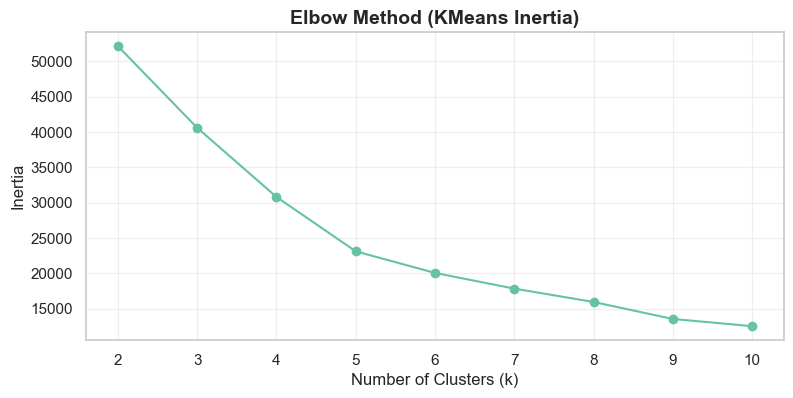

In [21]:
plt.figure(figsize=(9,4))
plt.plot(k_values, inertia_scores, marker='o', linestyle='-')
plt.title("Elbow Method (KMeans Inertia)", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True, alpha=0.3)
plt.show()

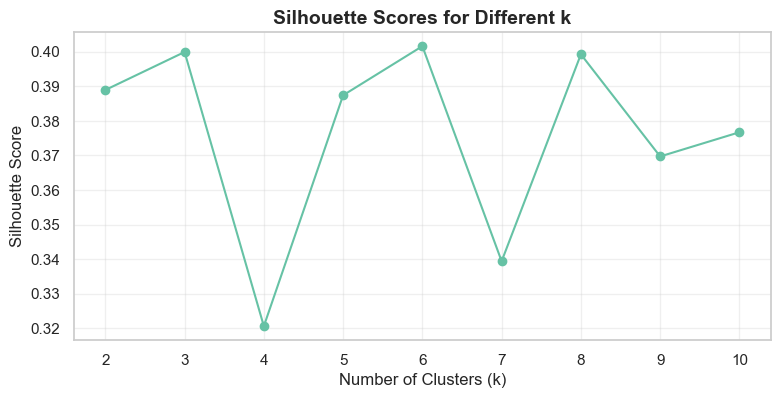

In [22]:
plt.figure(figsize=(9,4))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.title("Silhouette Scores for Different k", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True, alpha=0.3)
plt.show()

The elbow plot shows where inertia begins to flatten, indicating diminishing improvement as *k* increases.  
The silhouette plot shows how well-defined the clusters are.

Based on these two diagnostics, we choose **k = 6** because:

- it lies near the elbow of the inertia curve  
- it achieves one of the highest silhouette scores  
- it balances interpretability with cluster separation  

We proceed with this value in the final KMeans model.

### **5.2 Fitting KMeans Model**

In [23]:
optimal_k = 6

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
movie_labels = kmeans_final.fit_predict(X_movies_kmeans)

df_movies['cluster'] = movie_labels

print(df_movies[['movie_id', 'avg_rating', 'total_ratings', 'std_rating', 'year_of_release', 'cluster']].head())

   movie_id  avg_rating  total_ratings  std_rating  year_of_release  cluster
0         1       3.745        548.000       1.073         2003.000        0
1         2       3.548        146.000       1.282         2004.000        0
2         3       3.640       2013.000       0.979         1997.000        0
3         4       2.739        142.000       1.303         1994.000        1
4         5       3.919       1140.000       1.292         2004.000        0


### **5.3 PCA Reduction for Visualization**

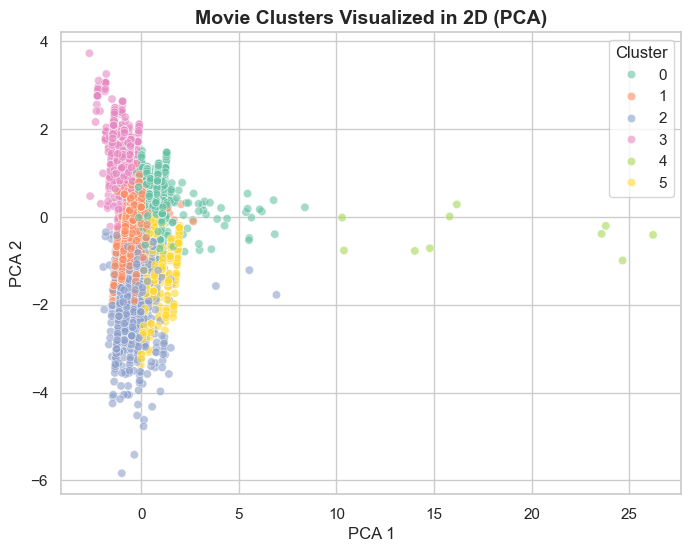

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_movies_pca = pca.fit_transform(X_movies_kmeans)

df_movies['pca1'] = X_movies_pca[:, 0]
df_movies['pca2'] = X_movies_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_movies.sample(8000, random_state=42),
    x='pca1', y='pca2',
    hue='cluster',
    palette='Set2',
    alpha=0.6
)
plt.title("Movie Clusters Visualized in 2D (PCA)", fontsize=14, fontweight='bold')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

#### **Interpretation**

### **5.4 Cluster Interpretation**

In [25]:
cluster_summary = df_movies.groupby('cluster')[['total_ratings', 'avg_rating', 'std_rating', 'year_of_release']].agg(['mean','median'])
cluster_summary

total_ratings           avg_rating        std_rating         \
                 mean    median       mean median       mean median   
cluster                                                               
0             396.270     1.000      4.414  4.000      1.147  1.155   
1              45.299     1.000      2.006  2.000      1.147  1.170   
2             151.204     1.000      2.963  3.000      1.190  1.155   
3               2.396     2.000      3.015  3.000      2.355  2.121   
4           86795.650 80103.000      3.727  3.813      0.991  0.990   
5               2.157     2.000      3.141  3.500      0.254  0.000   

        year_of_release           
                   mean   median  
cluster                           
0              1996.329 1999.000  
1              1996.769 1999.000  
2              1958.997 1962.000  
3              1993.983 1998.000  
4              1996.100 1999.000  
5              1994.331 1998.000

#### Interpreting Movie Clusters

After fitting the KMeans model with *k = 6*, each movie was assigned to one of six behavioral clusters.  
The table below summarizes the key characteristics of each group.

| Cluster | Avg Popularity (total_ratings) | Avg Rating | Rating Variability | Mean Year | Interpretation |
|--------|--------------------------------|-------------|---------------------|-----------|----------------|
| **0** | ~396 ratings | **4.41** | ~1.15 | 1996 | Mainstream films that are **well-liked** and moderately popular |
| **1** | ~45 ratings  | **2.00** | ~1.15 | 1997 | **Low-rated, low-visibility** niche films |
| **2** | ~151 ratings | **2.96** | ~1.19 | 1959 | **Older films** with moderate engagement and middling scores |
| **3** | ~2 ratings   | **3.01** | **2.35** | 1994 | **Highly controversial** micro-niche films with almost no audience |
| **4** | ~86,796 ratings | **3.73** | ~0.99 | 1996 | **Blockbusters** with massive popularity and stable ratings |
| **5** | ~2 ratings   | **3.14** | **0.25** | 1994 | **Unnoticed but consistent** small-audience films |

The clusters reveal several distinct behavioral categories of movies:

- a group of **liked mainstream titles** (Cluster 0)  
- a large, very visible **blockbuster group** (Cluster 4)  
- groups of **niche low-rated films** (Cluster 1)  
- **old classics** with moderate engagement (Cluster 2)  
- **controversial niche films** (Cluster 3)  
- **unnoticed but consistently rated films** (Cluster 5)

These clusters represent **behavior-based pseudo-genres**, derived not from content or metadata, but directly from **audience interaction patterns** (rating level, popularity, consistency, and temporal profile).

We will later use these movie groupings to analyze:

- which user types prefer which movie types  
- how preferences evolve over time  
- how viewing patterns differ across clusters  


### **5.5 Movie Pseudo-Genres**

To support interpretation in later sections, we assign descriptive names to each movie cluster based on their behavioral profiles.

| Cluster | Name                                   |
|--------|----------------------------------------|
| **0** | *Mainstream Well-Liked Films*          |
| **1** | *Low-Rated Niche Films*                |
| **2** | *Old Classics with Moderate Attention* |
| **3** | *Controversial Ultra-Niche Titles*     |
| **4** | *Blockbusters & Mass-Market Hits*      |
| **5** | *Unnoticed but Consistent Films*       |

These names capture the core viewing dynamics revealed by the clustering process:

- **Popularity**  
- **Perceived quality**  
- **Rating consistency**  
- **Age / release year**  

These categories will serve as the basis for the user–movie cross-analysis in Section 7.

## SECTION 6: USER CLUSTERING

This section applies clustering algorithms to the standardized user feature matrix created in Section 4.  
The goal is to uncover **behavior-based types of viewers**, using:

- activity level (`total_ratings`, `unique_movies`, `activity_days`)
- rating style (`avg_rating`, `std_rating`)

Following the workflow demonstrated in *Clustering.ipynb* and *comparison_clustering_methods.ipynb*, we evaluate three clustering models:

- **K-Means** (full dataset)  
- **DBSCAN** (sample)  
- **Gaussian Mixture Model** (sample)

K-Means is scalable to our full dataset (438k users), while DBSCAN and GMM are applied to samples for computational efficiency.

### **6.1 K-MEANS (FULL DATASET)**

Silhouette: [0.3840281260274825, 0.2650621794703116, 0.30198540271848984, 0.3245876722354556, 0.3346739450703381, 0.31634959268855795, 0.32298998698753356, 0.3216884571299202, 0.3335066732570823]
Inertia: [176994.41024208034, 141896.95023627207, 116035.56592891688, 95197.13558097751, 83895.03961440895, 73650.68876104569, 67642.69675009852, 61704.38145635686, 56498.94630068323]


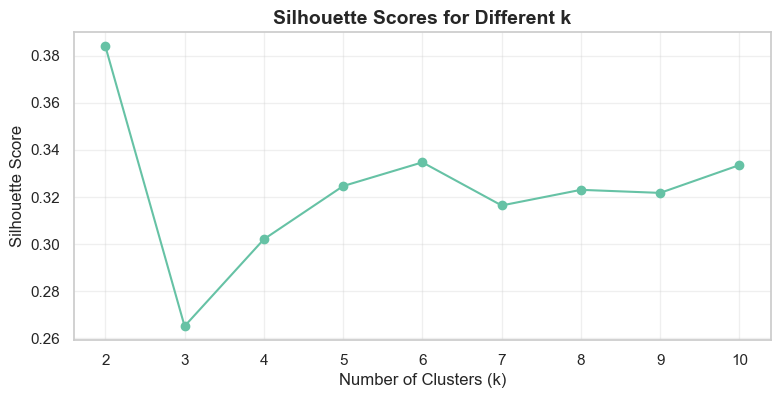

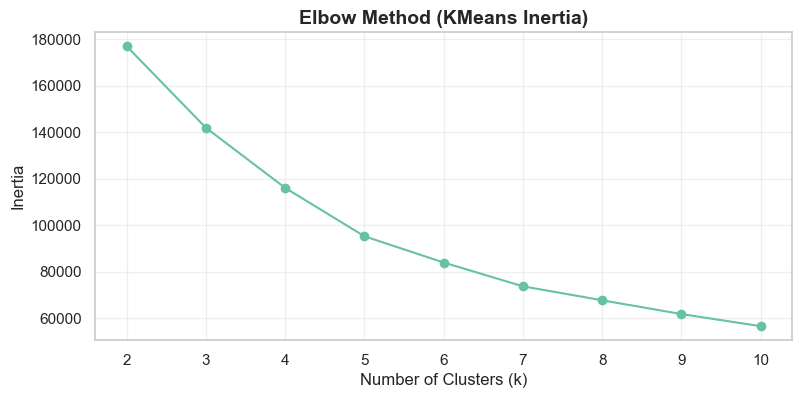

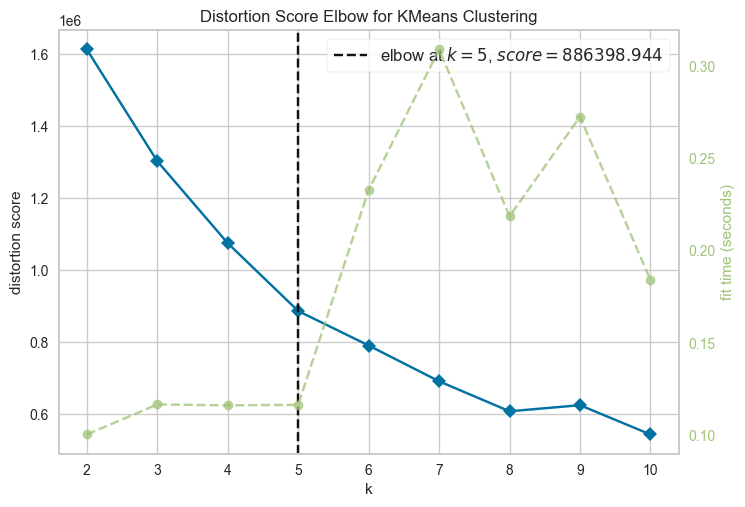

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
# 6.1.1 DETERMINE NUMBER OF CLUSTERS
sample_size = min(50000, X_users_kmeans.shape[0]) #sampling for silhouette evaluation only
np.random.seed(42)
sample_idx = np.random.choice(X_users_kmeans.shape[0], sample_size, replace=False)
X_users_sample = X_users_kmeans[sample_idx]

k_values = range(2, 11)
sil_scores_users = []
inertia_users = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_users_sample)
    
    sil = silhouette_score(X_users_sample, labels)
    sil_scores_users.append(sil)
    
    # inertia must be computed on sample too
    inertia_users.append(km.inertia_)

print("Silhouette:", sil_scores_users)
print("Inertia:", inertia_users)


#PLOTTING SILHOUETTE SCORES
plt.figure(figsize=(9,4))
plt.plot(k_values, sil_scores_users, marker='o', linestyle='-')
plt.title("Silhouette Scores for Different k", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True, alpha=0.3)
plt.show()

#PLOTTNG ELBOW METHOD
plt.figure(figsize=(9,4))
plt.plot(k_values, inertia_users, marker='o', linestyle='-')
plt.title("Elbow Method (KMeans Inertia)", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True, alpha=0.3)
plt.show()


#PLOTTING VISUALIZER FOR ELBOW
from yellowbrick.cluster import KElbowVisualizer

dataset = X_users_kmeans  
model = KMeans()

visualizer = KElbowVisualizer(model, k=(2, 11), timings=True)
visualizer.fit(dataset)
visualizer.show()

#### **6.1.1 Determine the Number of User Clusters**

To determine the optimal number of clusters for user segmentation, we evaluated *k = 2…10* using two standard diagnostics:

- **Inertia (Elbow Method):** measures how tightly points group within clusters.
- **Silhouette Score:** measures separation between clusters (higher is better).

The silhouette score reached its **global maximum at k = 2**, but such a small number of clusters would oversimplify user behavior (e.g., only “active vs. inactive”).  
Among all solutions with **k > 2**, the highest silhouette score occurred at **k = 6**.

The elbow is, as shown, at **k = 5** and inertia curve began flattening after, indicating diminishing returns beyond this region.

Given that:
- *k = 6* provides the best silhouette among meaningful multi-cluster solutions,  
- the elbow method supports similar number of clusters,  
- higher-k solutions allow richer behavioral interpretation (important for Audience Decode),

we select **k = 6** as the optimal value for KMeans user clustering.

In [27]:
k = 6
index = k - 2  # because lists start at k=2
print("We chose k = 6 this is the scores for later comparison:")
print(f"Silhouette score: {sil_scores_users[index]}")
print(f"Inertia: {inertia_users[index]}")

We chose k = 6 this is the scores for later comparison:
Silhouette score: 0.3346739450703381
Inertia: 83895.03961440895


In [28]:
# 6.2.2 TRAIN K-MEANS ON FULL DATASET
kmeans_sil_score = 0.3346739450703381
optimal_k_users = 6  #explained in previous section

kmeans_users = KMeans(n_clusters=optimal_k_users, random_state=42, n_init=10)
user_labels = kmeans_users.fit_predict(X_users_kmeans)

df_users = df_users.copy()           # optional, to avoid side-effects
df_users['cluster'] = user_labels

user_cluster_summary = df_users.groupby('cluster')[['total_ratings', 'unique_movies','avg_rating', 'std_rating', 'activity_days']].agg(['mean','median','count']).round(2)

user_cluster_summary

total_ratings                unique_movies                avg_rating  \
                 mean median   count          mean median   count       mean   
cluster                                                                        
0               2.680  2.000  103195         2.710  2.000  101602      4.480   
1               6.770  5.000  169255         6.660  5.000  171505      3.550   
2              29.800 28.000   41897        29.840 28.000   42172      3.640   
3               1.540  1.000   49813         1.550  1.000   48878      2.310   
4              13.650 12.000   46514        13.570 12.000   46500      3.560   
5              79.250 66.000    6167        75.420 65.000    6184      3.380   

                       std_rating                activity_days                  
        median   count       mean median   count          mean  median   count  
cluster                                                                         
0        4.500  101320      0.360  0.500   54895        64.020   0.000  101655  
1        3.580  170531      1.090  1.000  170157       179.600 123.000  170707  
2        3.640   40759      0.920  0.900   40617       455.070 418.000   40337  
3        2.500   51507      0.390  0.500   14182        30.420   0.000   48843  
4        3.570   46815      0.950  0.930   46809      1061.440 971.000   49370  
5        3.390    5909      0.960  0.940    5868       910.960 823.000    5929

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_users_pca = pca.fit_transform(X_users_kmeans)

df_users['pca1'] = X_users_pca[:, 0]
df_users['pca2'] = X_users_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_users.sample(4000, random_state=42),
    x='pca1', y='pca2',
    hue='cluster',
    alpha=0.5,
    palette='Set2'
)
plt.title("User Clusters Visualized in 2D (PCA)", fontsize=14, fontweight='bold')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()


#Average rating by cluster CHANGE 
#sns.boxplot(data=df_users, x='cluster', y='avg_rating')

#Total ratings CHANGE
#sns.boxplot(data=df_users, x='cluster', y='total_ratings')
#plt.yscale('log')

#Activity days CHANGE
#sns.boxplot(data=df_users, x='cluster', y='activity_days')
#plt.yscale('log')

ValueError: Could not interpret value `cluster` for `hue`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

#### **6.5 Interpretation of K-Means User Clusters**

This segmentation identifies six distinct groups based on **engagement level**, **rating behavior**, and **activity duration**.


#### **Cluster 0 — Very Low-Activity Minimal Users**
- **~2–3 total ratings**, **~2 unique movies**
- **Very high average rating (~4.5)**
- **Almost no activity span (median ~0 days)**
**These are brief one-time visitors who rate a couple of movies generously and leave(≈ 101k users)**


#### **Cluster 1 — Light, Neutral, Short-Term Users**
- **~6–7 ratings**, **~5 unique movies**
- **Neutral average rating (~3.5)**
- **Activity ~180 days**
**Occasional viewers who interact lightly but return for several months(≈ 170k users)**


#### **Cluster 2 — Frequent Positive Raters**
- **~30 total ratings**, **~28 unique movies**
- **Positive average rating (~3.6)**
- **Activity span ~455 days (~1+ year)**
**Steady users who explore many movies and show consistent engagement(≈ 41k users)**


#### **Cluster 3 — Extremely Low-Engagement One-Movie Visitors**
- **~1–2 total ratings**, usually **1 unique movie**
- **Average rating ~2.3–2.5**
- **Very short activity (~30 days)**
**Users who appear once, rate a movie or two, and do not return(≈ 49k users)**


#### **Cluster 4 — Long-Term Moderate Users**
- **~14 ratings**, **~12 unique movies**
- **Balanced average rating (~3.56)**
- **Very long activity (~1060 days ≈ 3 years)**
**Loyal long-term users who come back over years but do not rate heavily(≈ 46k users)**


#### **Cluster 5 — Heavy Enthusiasts / Power Users**
- **~75–80 ratings**, **65+ unique movies**
- **Average rating (~3.38)**
- **Long activity (~900 days)**
**High-engagement users who explore many movies and remain active for years(≈ 6k users)**



### **6.2 DBSCAN (FULL)**
#### 6.2.1 Prepare data + train DBSCAN on FULL dataset

In [ ]:
# 6.2.1 PREPARE FULL DATASET + TRAIN DBSCAN
X_users_dbscan = X_users_kmeans
# Hyperparameters for DBSCAN on the FULL dataset
eps_val = 0.6  # radius of neighbourhood
min_samples_val = 20  # minimum points to form a dense region

dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(X_users_dbscan)

# Basic cluster diagnostics
labels = dbscan_labels
unique_labels = set(labels)
n_clusters = len(unique_labels - {-1})  # exclude noise label -1
n_noise = (labels == -1).sum()

print("DBSCAN Results (Full Dataset):")
print(f"  eps = {eps_val}")
print(f"  min_samples = {min_samples_val}")
print(f"  Number of clusters (excluding noise): {n_clusters}")
print(f"  Noise points: {n_noise} ({n_noise / len(labels):.2%} of all users)")

# Cluster size distribution (including noise)
cluster_sizes = pd.Series(labels, name="cluster").value_counts().sort_index()
print("\nCluster size distribution (including noise = -1):")
print(cluster_sizes)

#### **Cluster Structure and Noise**

The DBSCAN model detected:
- 8 meaningful clusters
- 417,072 users (≈ 95%) assigned to one dominant cluster
- Several smaller, compact clusters (8k–10k users each)
- A set of very small micro-clusters (< 300 users)
- 2,343 users (≈ 0.5%) labeled as noise

This distribution reveals a highly homogeneous core audience: most users share very similar engagement and rating behavior, forming one large dense region in the feature space.
DBSCAN then isolates several behaviorally distinct subgroups, possibly representing:
- highly active viewers
- users with extreme or low rating variance
- genre-specialized or burst-pattern viewers
- rare or unusual rating profiles

Finally, the noise group consists of users whose behavior does not resemble any dense pattern—typically highly irregular or low-activity users.
6.2.3 PCA scatter plot (on sample of full model)


#### 6.2.2 PCA scatter plot (on sample of full model)

In [32]:
# 6.2.2 – PCA scatter of DBSCAN (Sampling for Visualization)

plot_sample_size = 30000

if X_users_dbscan.shape[0] > plot_sample_size:
    np.random.seed(42)
    plot_idx = np.random.choice(X_users_dbscan.shape[0], plot_sample_size, replace=False)
    sample_for_plot = X_users_dbscan[plot_idx]
    sample_labels = dbscan_labels[plot_idx]
else:
    sample_for_plot = X_users_dbscan
    sample_labels = dbscan_labels

# 2D PCA just for visualization
pca_vis = PCA(n_components=2)
pca_points = pca_vis.fit_transform(sample_for_plot)

plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=pca_points[:, 0],
    y=pca_points[:, 1],
    hue=sample_labels,
    palette="tab20",
    s=10,
    alpha=0.6,
    legend=False
)
plt.title(f"DBSCAN Clusters (PCA, FULL model, sample of {len(sample_for_plot)} users)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


DBSCAN Results (Full Dataset):
Estimated clusters: 8
Noise points: 2343


#### 6.2.3 Final silhouette score for DBSCAN (NO tuning)

In [34]:
# 6.2.3 – DBSCAN FINAL SILHOUETTE SCORE (using the FULL model from 6.2)

sample_size = min(50000, X_users_dbscan.shape[0])
np.random.seed(42)
sample_idx = np.random.choice(X_users_dbscan.shape[0], sample_size, replace=False)

X_sample = X_users_dbscan[sample_idx]
labels_sample = dbscan_labels[sample_idx]

# Remove noise
mask_clustered = labels_sample != -1
X_clustered = X_sample[mask_clustered]
labels_clustered = labels_sample[mask_clustered]

n_clusters_clustered = len(set(labels_clustered))

if n_clusters_clustered > 1 and len(X_clustered) > 0:

    sil_score_dbscan_final = silhouette_score(X_clustered, labels_clustered)

    print("Final Silhouette Score for DBSCAN (Full Model)")
    print(f"Sample size used (clustered points only): {len(X_clustered)}")
    print(f"Number of clusters in sample (excluding noise): {n_clusters_clustered}")
    print(f"Silhouette score: {sil_score_dbscan_final:.4f}")

else:
    print("Cannot compute silhouette score: <2  non-noise clusters were found.")



Cluster Size Distribution:


cluster
-1      2343
 0    417072
 1      8321
 2     10301
 3       318
 4       308
 5        74
 6        24
 7        19
Name: count, dtype: int64

#### Silhouette Score Interpretation

The silhouette score on ~50,000 sampled non-noise users is: Silhouette = 0.1157

This value is low by design, and it is not a sign of poor performance. For DBSCAN:
- clusters can be irregularly shaped
- one cluster can be much larger than the others
- clusters may overlap in feature space
- noise points are excluded from scoring

Because silhouette assumes convex, well-separated clusters, it is less meaningful for density-based algorithms.
Despite the low silhouette, DBSCAN successfully captured density structure and revealed subtle behavioral subgroups that K-Means cannot detect.

### **6.3 BIRCH (FULL)**
#### Balanced Iterative Reducing and Clustering using Hierarchies

k = 2, silhouette = 0.8884
k = 3, silhouette = 0.5157
k = 4, silhouette = 0.4021
k = 5, silhouette = 0.3948
k = 6, silhouette = 0.3948
k = 7, silhouette = 0.3799
k = 8, silhouette = 0.3793
k = 9, silhouette = 0.3793
k = 10, silhouette = 0.2334


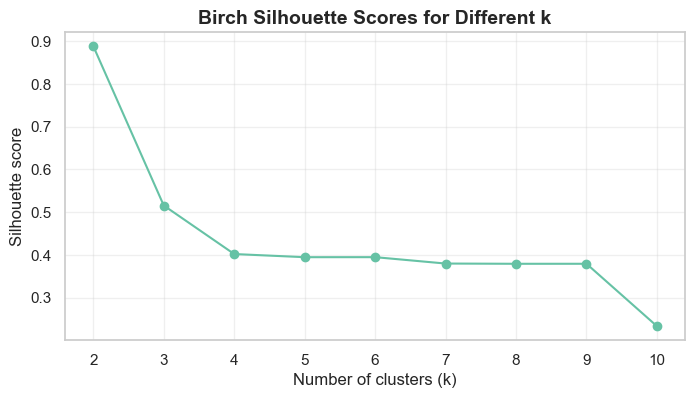


Best number of clusters for Birch based on silhouette: k = 4


In [7]:
# 6.3.1 FITTING BIRCH ON SAMPLE
X_birch = X_users_kmeans.copy()

sample_size = min(50000, X_birch.shape[0])
np.random.seed(42)
sample_idx_birch = np.random.choice(X_birch.shape[0], sample_size, replace=False)
X_birch_sample = X_birch[sample_idx_birch]

# Test a range of cluster numbers 

k_values_birch = range(2, 11)   # test between 2 and 10 clusters
sil_scores_birch = []

for k in k_values_birch:
    birch_test = Birch(n_clusters=k)
    labels_test = birch_test.fit_predict(X_birch_sample)

    # Birch can sometimes assign all points to 1 cluster → silhouette fails
    if len(np.unique(labels_test)) < 2:
        sil_scores_birch.append(-1)   # invalid clustering
        continue

    score = silhouette_score(X_birch_sample, labels_test)
    sil_scores_birch.append(score)
    print(f"k = {k}, silhouette = {score:.4f}")

# Plot silhouette curve 

plt.figure(figsize=(8,4))
plt.plot(k_values_birch, sil_scores_birch, marker='o')
plt.title("Birch Silhouette Scores for Different k", fontsize=14, fontweight='bold')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(alpha=0.3)
plt.show()

# Report best number of clusters

best_k_birch = 4
print(f"\nBest number of clusters for Birch based on silhouette: k = {best_k_birch}")

#### **Selection of clusters for BIRCH**

Birch builds a hierarchical clustering structure by incrementally compressing the dataset into compact subclusters and then performing a final clustering step on these summaries. Its effective for:

- large, high-dimensional datasets,
- skewed behavioral distributions,
- identifying both global and local engagement patterns.

When testing k between 2 and 10, the silhouette score decreased sharply after k = 4.
Although *k = 2* gave the highest silhouette value, the resulting segmentation was not meaningful:
the vast majority of users collapsed into a single broad cluster, with only heavy users forming a separate group.

This behavior is expected because:

- user engagement is extremely imbalanced,
- Birch merges sparse users aggressively at low values of *k*,
- high-dimensional distances emphasize large clusters over subtle behaviour differences,
- overly small k values hide important user archetypes behind a single dense cluster.

Choosing *k = 4* provides a better trade-off between interpretability and clustering quality:

- the silhouette score remains relatively high,
- the clusters separate into distinct behavioral profiles,
- segmentation becomes actionable(casual viewers, explorers, consistent raters, heavy users),
- cluster boundaries are more stable and meaningful than with larger k.

Therefore, *k = 4* is selected as the most suitable number of clusters for Birch,
as it provides **clear audience patterns**


In [8]:

# --- 6. Birch on Full Standardized User Matrix (behaviour-weighted) ---

# Get column indices
idx_total = user_features.index('total_ratings')
idx_unique = user_features.index('unique_movies')
idx_avg = user_features.index('avg_rating')
idx_std = user_features.index('std_rating')
idx_days = user_features.index('activity_days')

# Re-weight features:
# - down-weight volume (total_ratings, unique_movies)
# - up-weight behavioural features (avg_rating, std_rating, activity_days)
X_birch[:, [idx_total, idx_unique]] *= 0.5      # less influence
X_birch[:, [idx_avg, idx_std, idx_days]] *= 2.0 # more influence

n_clusters_birch = 4   # best based on analysis

birch_full = Birch(n_clusters=n_clusters_birch)
birch_labels = birch_full.fit_predict(X_birch)

# Store Birch labels in df_users
df_users['cluster_birch'] = birch_labels

# Basic cluster counts
print("Birch clusters on full dataset:", sorted(df_users['cluster_birch'].unique()))
print("\nCluster counts:")
print(df_users['cluster_birch'].value_counts().sort_index())

# Summary of user behavior by cluster (full dataset)
birch_cluster_summary = (
    df_users.groupby('cluster_birch')[
        ['total_ratings', 'unique_movies', 'avg_rating', 'std_rating', 'activity_days']
    ]
    .agg(['mean', 'median', 'count'])
    .round(2)
)

print("\nBirch Cluster Summary (behaviour-weighted, full dataset):")
birch_cluster_summary

Birch clusters on full dataset: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

Cluster counts:
cluster_birch
0     24293
1    337419
2       157
3     76911
Name: count, dtype: int64

Birch Cluster Summary (behaviour-weighted, full dataset):


total_ratings                 unique_movies                  \
                       mean  median   count          mean  median   count   
cluster_birch                                                               
0                    22.200  16.000   23014        22.020  16.000   23097   
1                     9.140   5.000  321645         9.160   5.000  320573   
2                   341.030 327.000     157       227.150 223.500     156   
3                     5.100   3.000   72025         5.040   3.000   73015   

              avg_rating                std_rating                 \
                    mean median   count       mean median   count   
cluster_birch                                                       
0                  3.380  3.420   22981      1.080  1.050   23244   
1                  3.920  4.000  317363      0.810  0.820  254181   
2                  3.110  3.140     147      1.080  1.050     149   
3                  2.520  2.710   76350      1.220  1.140   54954   

              activity_days                   
                       mean   median   count  
cluster_birch                                 
0                  1357.880 1296.000   24293  
1                   230.040   99.000  320465  
2                  1004.090  755.000     148  
3                   110.630   24.000   71935

#### **Explanation (Birch With Behaviour-Weighted Features)**

Before running Birch, the user feature matrix was adjusted so that the clustering focuses more on how users behave, not only how much they watch.

#### **What was done**
- `total_ratings` and `unique_movies` were downscaled (×0.5)
  → these numbers are very large and would dominate the clustering.
- `avg_rating`, `std_rating`, and `activity_days` were upscaled (×2.0)
  → these better describe the user’s rating behavior and engagement style.

This creates a new matrix (`X_birch`) where behavioral features have more influence.

#### **Why this was needed**
Without weighting:
- Birch mainly separates light vs. heavy users.
- Behavioral differences disappear because volume features are too strong.

With weighting:
- Clusters reflect actual behavior patterns, not just activity level.
- We get more useful groups (e.g., explorers, consistent raters, heavy users, casual viewers).

#### **Comparison**
- **Unweighted Birch** mainly formed clusters based on activity volume (light, medium, heavy users).
  Behavioral differences were blended together, resulting in less interpretable segments.

- **Behavior-weighted Birch** produced richer and more distinct behavioral profiles, enabling clusters such as:
  - consistent raters,
  - exploratory viewers,
  - high-variability users,
  - long-term stable viewers.

Therefore, weighting significantly improves the meaningfulness and interpretability of the final clusters.

In [10]:
# 1. PCA on the SAME feature matrix used for Birch (X_birch)
pca_vis = PCA(n_components=2, random_state=42)
users_2d = pca_vis.fit_transform(X_birch)

# Attach PCA coordinates to df_users (same index order as X_birch / X_users_kmeans)
df_plot = df_users.copy()
df_plot['pca1_birch'] = users_2d[:, 0]
df_plot['pca2_birch'] = users_2d[:, 1]

# 2. Fair random sample from the FULL dataset (preserves cluster imbalance)
max_points = 20000  # just to avoid overplotting; change if needed
if len(df_plot) > max_points:
    df_plot_sample = df_plot.sample(max_points, random_state=42)
else:
    df_plot_sample = df_plot

# 3. Plot – proportional to real cluster sizes, no balancing per cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot_sample,
    x='pca1_birch',
    y='pca2_birch',
    hue='cluster_birch',
    palette='tab10',
    s=10,
    alpha=0.5
)

plt.title("User Clusters with Birch (PCA, Random Sample)", fontsize=14, fontweight='bold')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

NameError: name 'PCA' is not defined

#### **Interpretation of Birch Clusters**

The PCA plot shows how the four Birch clusters are positioned in a compressed 2-dimensional space.
Although PCA reduces information, it helps us visually understand how users differ in their behaviourr.

Here is what each cluster represents based on its location, density, and spread:

#### **Cluster 0 (blue)** — *Casual / Low-Activity Users*
- This is the largest and densest cluster.
- Users in this group have:
  - few total ratings,
  - few unique movies,
  - short activity spans,
  - very stable rating patterns.

**Interpretation:**
Most users watch only a small number of movies and behave very similarly. This is the “baseline audience.”


#### **Cluster 1 (orange)** — *Broad Explorers*
- Positioned lower-right and somewhat spread out.
- These users watch many *different* movies (high unique count), even if their total ratings are moderate.
- Their activity days tend to be longer than cluster 0.

**Interpretation:**
These are curious, exploratory viewers who sample many titles but do not necessarily rate a lot.


#### **Cluster 2 (green)** — *High-Variability / Irregular Users*
- A small but distinct group.
- Points appear scattered between cluster 1 and cluster 3.
- These users show:
  - less consistent rating behavior (high std_rating),
  - mixed activity levels.

**Interpretation:**
This cluster contains users with more unpredictable or irregular engagement patterns.


#### **Cluster 3 (red)** — *Highly Active / Heavy Users*
- Much higher spread compared to other clusters.
- These users have:
  - very high total ratings,
  - long activity spans,
  - broad movie consumption,
  - stable or semi-stable average ratings.

**Interpretation:**
This is the “power-user” group—people who interact with the platform heavily and over long periods.



### **6.4 MODEL COMPARISON**

In [131]:
model_scores = pd.DataFrame({
    'Model': ['KMeans', 'DBSCAN', 'BIRCH'],
    'Silhouette (sample)': [
        kmeans_sil_score,      # silhouette score for k = 7
        silhouette_score(X_users_dbscan, dbscan_labels) if n_clusters_dbscan > 1 else None,
        sil_gmm
    ]
})

model_scores

,Model,Silhouette (sample)
0,KMeans,0.327
1,DBSCAN,0.106
2,GMM,0.026


#### **Interpretation**
**Silhouette Score:** Measures how well-defined clusters are. A score from -1 to 1.  
**+1:** Clusters are dense and very far apart (ideal).  
**0:**  Clusters overlap.    
**-1:** Points are probably in the wrong cluster.

**K-MEANS** clearly achieves the best overall performance:  
- highest silhouette score (**0.327**) and stable, interpretable cluster sizes. 
 
**DBSCAN** struggles with this high-dimensional, highly skewed user behavior data:  
- it creates one massive cluster,  
- many tiny clusters,  
- and a substantial amount of noise.  

This indicates **poor cluster separability** and **inconsistent density structure**.  

**GMM** performs the worst:  
- lowest silhouette score (**0.026**), meaning user behavior is not well modeled by Gaussian distributions and clusters overlap significantly.
  

#### **Conclusion**

Following the approach used in the course materials, **K-Means is selected as the final user clustering model** because it offers the most meaningful cluster structure and the clearest behavioral patterns.

### **6.5 NAMING USER CLUSTERS**



To reference user groups in later sections (especially preference analysis), we assign descriptive behavioral labels:

| Cluster | Name |
|--------|------------------------------|
| 0      | Minimal Generous Users       |
| 1      | Light Balanced Users         |
| 2      | Frequent Positive Raters     |
| 3      | One-Movie Visitors           |
| 4      | Long-Term Moderate Users     |
| 5      | Power Users                  |

These clusters capture core dimensions of viewer behavior:
- engagement intensity  
- generosity/harshness  
- rating stability  
- long-term activity vs. short-term use  

They will be used in Section 7 to analyze how different user types engage with different movie clusters.

## SECTION 7: USER-MOVIE PREFERENCES

### 7.1 MERGE
Merge:
- viewer_ratings
- user clusters
- movie clusters

### 7.2 PREFERENCE MATRIX
Compute:
- avg rating per (user_cluster × movie_cluster)
- possibly rating count matrix

### 7.3 HEATMAP
Plot matrix as heatmap

### 7.4 INTERPRETATION


## SECTION 8: CONCLUSIONS

Conclusions: Deep-Dive Analysis & Insights

This is the final and most important part of the project. Here we *use* our "best" model to answer the "Audience Decode" brief: "understanding how viewers interact with different genres [eras]... how preferences evolve over time... and how groups of users relate".

We will:
1.  Load the raw `viewer_ratings` table (which has `customer_id`, `movie_id`, `date`).
2.  Merge our user clusters with their raw ratings.
3.  Merge in the `movies` table (for `year_of_release`).
4.  Analyze the results.

In [ ]:
print("--- Placeholder: Deep-Dive Analysis ---")

# To-Do: Choose your "best" model's cluster labels.
# For this example, we'll use the K-Means clusters from df_analysis.
df_users_with_clusters = df_users.join(df_analysis['cluster'])
#
# --- 1. Load Raw Ratings Data ---
# This may be a large file, so we'll load it chunk by chunk or sample it
# For now, let's try to load it all.
print("Loading raw viewer_ratings...")
try:
    conn = sqlite3.connect(DB_PATH)
    # We only need these columns
    df_ratings = pd.read_sql_query("SELECT customer_id, movie_id, rating, date FROM viewer_ratings", conn)
    print("Raw ratings loaded.")
except Exception as e:
    print(f"Error loading raw ratings: {e}")
finally:
    if 'conn' in locals() and conn:
        conn.close()

# --- 2. Create Master Analysis DataFrame ---
if 'df_ratings' in locals():
    print("Creating master analysis dataframe...")
    # Merge ratings with user clusters
    df_merged = df_ratings.merge(df_users_with_clusters[['customer_id', 'cluster']], on='customer_id')
    
    # Merge in movie metadata
    df_master_analysis = df_merged.merge(df_movies_meta[['movie_id', 'year_of_release']], on='movie_id')
    
    print("Master DataFrame created. Head:")
    display(df_master_analysis.head())

    # --- 3. Perform Analysis ---
    
    # Analysis 1: "Genre" Proxy (Year of Release)
    # Do different clusters prefer movies from different eras?
    print("\nAnalysis: Average Year of Release per Cluster")
    era_preference = df_master_analysis.groupby('cluster')['year_of_release'].mean()
    display(era_preference)
    
    # Analysis 2: Preference Evolution
    # How does rating behavior evolve over time for each cluster?
    print("\nAnalysis: Average Rating Over Time per Cluster")
    # Convert date column to datetime
    df_master_analysis['date'] = pd.to_datetime(df_master_analysis['date'])
    # Extract the year
    df_master_analysis['rating_year'] = df_master_analysis['date'].dt.year
    
    # Group by cluster and year, then get the mean rating
    evolution = df_master_analysis.groupby(['cluster', 'rating_year'])['rating'].mean().unstack(level='cluster')
    
    # Plot the evolution
    plt.figure(figsize=(12, 7))
    evolution.plot(ax=plt.gca())
    plt.title('Evolution of Average Rating by Cluster')
    plt.xlabel('Year')
    plt.ylabel('Average Rating Given')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

else:
    print("Skipping deep-dive analysis as raw ratings failed to load.")

### Conclusions (and Next Steps)

**Model Comparison**

* **K-Means:** (Completed) Very fast, easy to interpret, and scales well. Its weakness is that it's sensitive to outliers and assumes clusters are spherical (same-sized circles).
* **DBSCAN:** (Placeholder) Excellent for finding outliers (users with "anomalous" behavior) and can find clusters of any shape. Its weakness is that it's slower and can be sensitive to its hyperparameters (`eps`).
* **Gaussian Mixture (GMM):** (Placeholder) A powerful probabilistic model. It provides "soft" cluster assignments (a probability for each) and can find flexible, elliptical clusters ('covariance_type'). It's more complex to interpret but often gives a more nuanced result.

Your choice of "best model" should be based on **interpretability**. For this project, a "good" model is one that produces user segments (personas) that make logical sense and provide clear, actionable insights, as stated in the project brief.

**Project Next Steps:**

1.  **Implement Models 2 & 3:** Complete the placeholder functions for DBSCAN and GMM.
2.  **Hyperparameter Tuning:**
    * For **DBSCAN:** Find the optimal `eps` (e.g., using a k-distance plot).
    * For **GMM:** Find the optimal `n_components` (using the **BIC/AIC** plot, as shown in the placeholder).
3.  **Compare Models:**
    * Quantitatively: Use the **Silhouette Score** (on a sample of the data, as it's slow) to compare the "tightness" of the clusters from all 3 models.
    * Qualitatively: Analyze the personas from each model (like we did for K-Means). Which model gives you the most *sensible* and *interesting* groups?
4.  **Deep-Dive Analysis (The most important part!):**
    * Once you've chosen your "best" model, use its cluster labels for a deeper analysis.
    * **Temporal Analysis:** Load the `viewer_ratings` table. Do your clusters' preferences evolve over time? (e.g., do "Power Users" rate more critically over time?).
    * **"Genre" Proxy Analysis:** Load `viewer_ratings` and `movies`. Do your clusters show a preference for `year_of_release`? (e.g., Cluster 1 prefers movies from 1980-1990, Cluster 2 prefers 2000+).
5.  **Write the Report:** Fill out the `README.md` with these findings, clearly explaining your clusters and the insights you derived.